# Transfer Learning - Dropouts
Rather than needing to train a neural network from scratch we can need a lot of data and take a long time to train, you can instead download an open-source model that someone else has already trained on a huge dataset and use those parameters as a starting point to then train your model just a little bit more on perhaps a smaller dataset that you have for a given task, so it is called **Transfer Learning**. 

The idea behind **Dropouts** is that they remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit!

In [5]:
########################################### Import and load the pretrained weights #######################################
import os

from tensorflow.keras import layers                                              # To understand which ones to use, and which ones to retrain
from tensorflow.keras import Model
                                                                                 # The weights are saved in this URL
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  
  
  
from tensorflow.keras.applications.inception_v3 import InceptionV3               # Incept the model and load the trained weights

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:                                           # For each layer in the model, we lock them to avoid retraining
  layer.trainable = False

# pre_trained_model.summary()                                                    # The summary of this model will print a lot of information

last_layer = pre_trained_model.get_layer('mixed7')                               # The last Conv layer is 3x3, but we want our output layer have more info
print('last layer output shape: ', last_layer.output_shape)                      # so we moved to 'mixed7', it is a 7x7 Conv layer

last_output = last_layer.output                                                  # output of last_layer will be used as our DNN input then.

--2019-10-20 20:36:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  92.3MB/s    in 0.9s    

2019-10-20 20:36:40 (92.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
last layer output shape:  (None, 7, 7, 768)


In [6]:
########################################### Add Deep Neural Network underneath to adjust model for own #######################################
from tensorflow.keras.optimizers import RMSprop

# DNN change the output layers of pre-trained model for our own cases

x = layers.Flatten()(last_output)               # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x)    # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                      # Add a dropout rate of 0.2, a way of regularization to avoid overfitting           
x = layers.Dense  (1, activation='sigmoid')(x)  # Add a final sigmoid layer for classification            

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001),   # Compile the model
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
########################################### Load images and define training/validation datasets #######################################
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'                                   # we use dog vs cat datasets

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


#train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures                 # These lines were for exploring the data
#train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures                 # not for training the model
#validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
#validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures
#train_cat_fnames = os.listdir(train_cats_dir)
#train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2019-10-20 20:54:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  83.5MB/s    in 0.8s    

2019-10-20 20:54:41 (83.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
########################################### Training the model #######################################
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
Epoch 1/20
100/100 - 30s - loss: 0.4802 - acc: 0.7685 - val_loss: 0.3022 - val_acc: 0.9070
Epoch 2/20
Epoch 1/20
100/100 - 21s - loss: 0.4037 - acc: 0.8230 - val_loss: 0.2646 - val_acc: 0.9330
Epoch 3/20
Epoch 1/20
100/100 - 22s - loss: 0.3437 - acc: 0.8515 - val_loss: 0.3234 - val_acc: 0.9360
Epoch 4/20
Epoch 1/20
100/100 - 21s - loss: 0.3483 - acc: 0.8565 - val_loss: 0.5528 - val_acc: 0.9150
Epoch 5/20
Epoch 1/20
100/100 - 21s - loss: 0.3153 - acc: 0.8740 - val_loss: 0.3695 - val_acc: 0.9400
Epoch 6/20
Epoch 1/20
100/100 - 21s - loss: 0.3118 - acc: 0.8745 - val_loss: 0.3289 - val_acc: 0.9490
Epoch 7/20
Epoch 1/20
100/100 - 21s - loss: 0.2851 - acc: 0.8805 - val_loss: 0.4251 - val_acc: 0.9410
Epoch 8/20
Epoch 1/20
100/100 - 21s - loss: 0.3038 - acc: 0.8730 - val_loss: 0.3475 - val_acc: 0.9480
Epoch 9/20
Epoch 1/20
100/100 - 21s - loss: 0.2781 - acc: 0.8885 - val_loss: 0.3015 - val_acc: 0.9590
Epoch 10/20
Epoch 1/20
100/100 - 22s - loss: 0.2785 - acc: 0.8890 - val_loss: 0.34

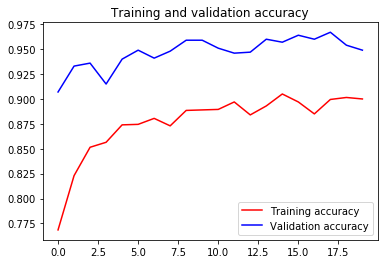

<Figure size 432x288 with 0 Axes>

In [9]:
########################################### Plot the accuracy of training/validation datasets #######################################
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()